# Flatiron Data Science - Project 2
## Building a Linear Regression Model<br>Kings County Housing Prices Bakeoff

Khyatee Desai<br>October 23, 2020

# Step 1: Read in Data

In [920]:
import pandas as pd
import numpy as np
from geopy import distance
from geopy import Point
import matplotlib.pyplot as plt
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [921]:
# read in training dataset
df = pd.read_csv('kc_house_data_train.csv')

# Data Cleaning

In [922]:
df.isnull().sum().any()

False

In [923]:
df.dtypes

Unnamed: 0         int64
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### Change date strings to datetime

In [924]:
df['yr_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.year
df.drop('date',axis=1,inplace=True)

### Drop first two columns because the aren't relevant

In [925]:
df.drop(columns=['Unnamed: 0', 'id'],axis=1,inplace=True)
df.sort_values('price', ascending=False).head(5)

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
10366  7700000.0         6       8.00        12050     27600     2.5   
6903   7062500.0         5       4.50        10040     37325     2.0   
7519   6885000.0         6       7.75         9890     31374     2.0   
2232   5570000.0         5       5.75         9200     35069     2.0   
1979   5350000.0         5       5.00         8000     23985     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
10366           0     3          4     13        8570           3480   
6903            1     2          3     11        7680           2360   
7519            0     4          3     13        8860           1030   
2232            0     0          3     13        6200           3000   
1979            0     4          3     12        6720           1280   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
10366      1910          1987    98102  47.6298 -122.323           3940   
6903       1940          2001    98004  47.6500 -122.214           3930   
7519       2001             0    98039  47.6305 -122.240           4540   
2232       2001             0    98039  47.6289 -122.233           3560   
1979       2009             0    98004  47.6232 -122.220           4600   

       sqft_lot15  yr_sold  
10366        8800     2014  
6903        25449     2014  
7519        42730     2014  
2232        24345     2014  
1979        21750     2015

### Check Baseline Regression R-squared Value

In [926]:
y = df[['price']]
X = df.iloc[:,1:]
baseline = LinearRegression()
baseline.fit(X,y)
baseline.score(X,y)

0.6995126205083237

# Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  
Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

- **Exploratory Data Analysis (EDA)**: You must create at least 4 data visualizations that help to explain the data. These visualizations should help someone unfamiliar with the data understand the target variable and the features that help explain that target variable.
- **Statistical Tests**: Your notebook must show at least 3 statistical tests that you preformed on your data set. Think of these as being part of your EDA process; for example, if you think houses with a view cost more than those without a view, then perform a two-sample T-test. These can be preliminary evidence that a feature will be important in your model.


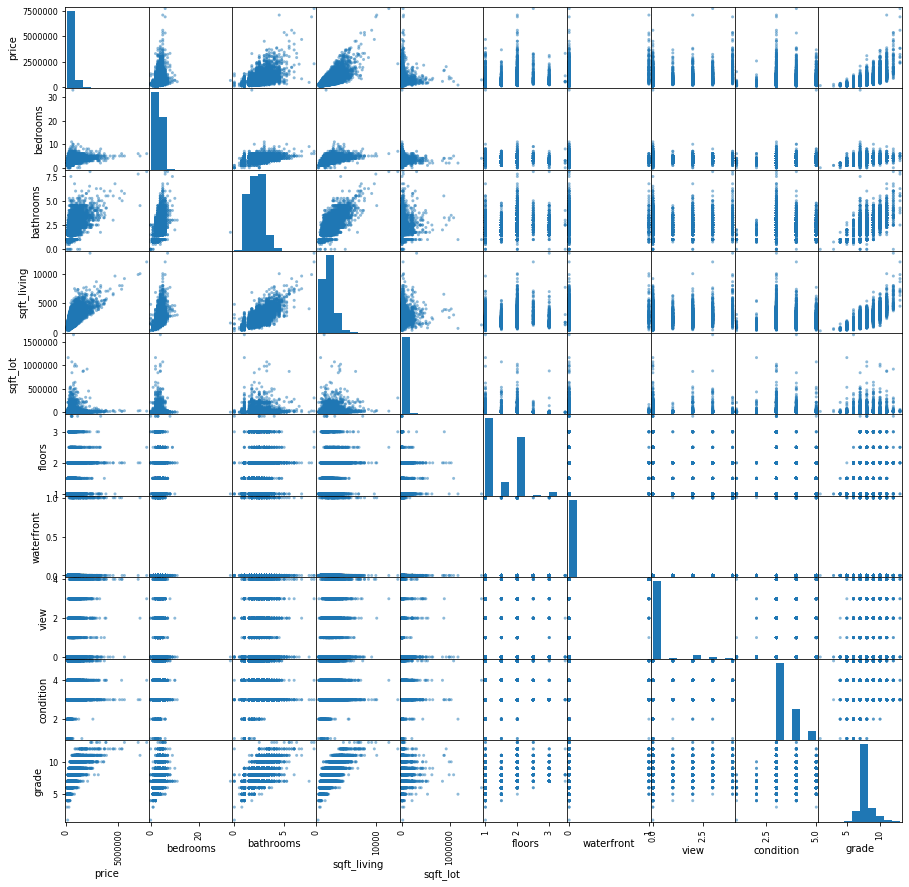

In [912]:
pd.plotting.scatter_matrix(df.iloc[:,:8], figsize= [15,15]);

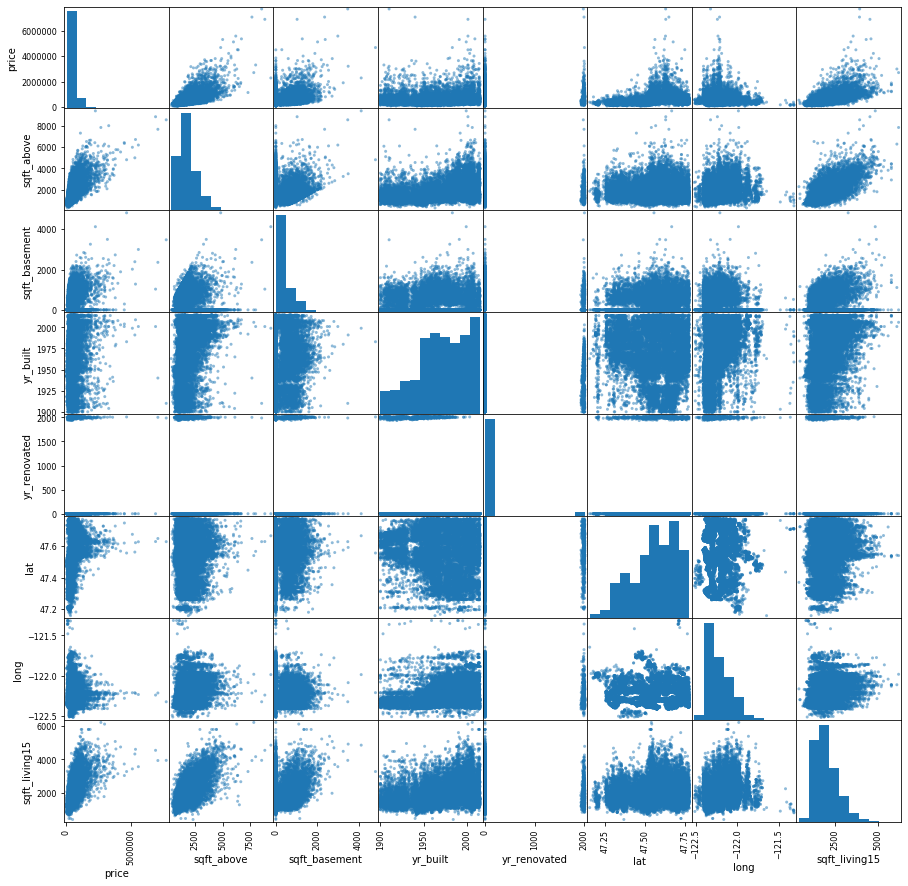

In [913]:
df2 = pd.concat([df['price'],df.iloc[:,8:16]], axis=1)
pd.plotting.scatter_matrix(df2, figsize= [15,15]);

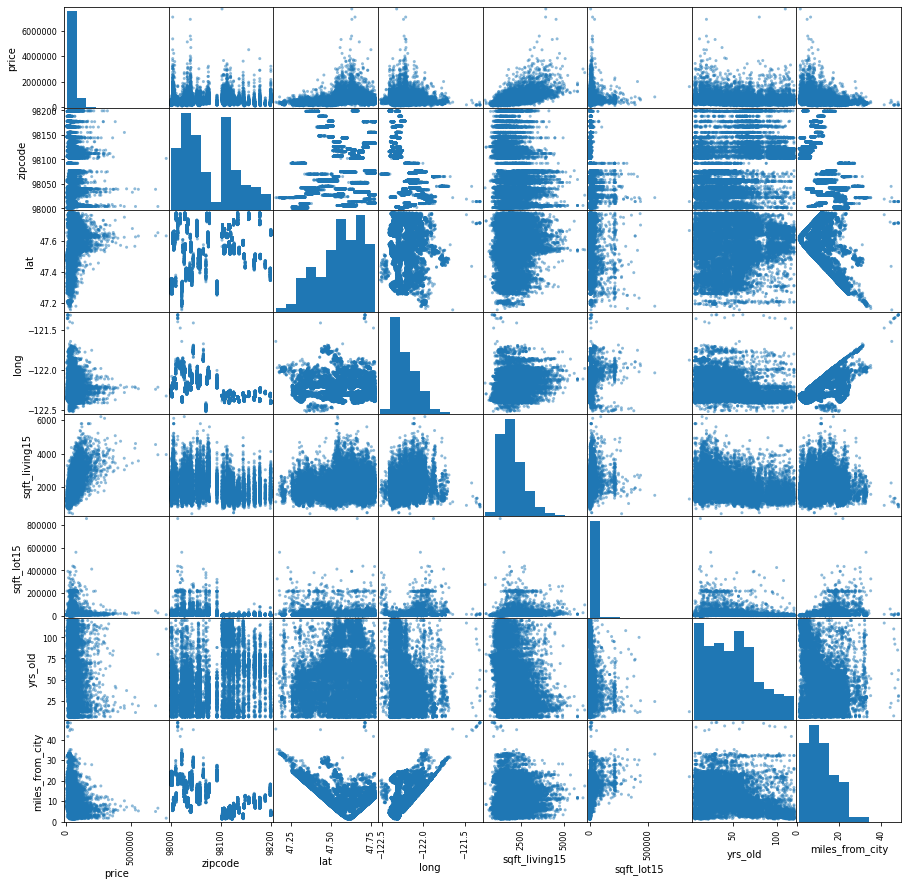

In [536]:
df3 = pd.concat([df['price'],df.iloc[:,16:]], axis=1)
pd.plotting.scatter_matrix(df3, figsize= [15,15]);

# Step 4: Feature Engineering

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.
- **Feature Engineering**: You must create at least 3 new features to test in your model. Those features do not have to make it into your final model, as they might be removed during the feature selection process. That is expected, but you still need to explain the features you engineer and your thought process behind why you thought they would explain the selling price of the house.

## Zipcode Dummy Variables

In [927]:
# Create dummy variables for zip code 
zip_dummies = pd.get_dummies(df['zipcode'].astype(str), dtype=int, drop_first=True)
df.drop(columns=['zipcode'],inplace=True)
new_cols = 'zip'+zip_dummies.columns
zip_dummies.columns = new_cols
zip_dummies.head()

zip98002  zip98003  zip98004  zip98005  zip98006  zip98007  zip98008  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         1         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   zip98010  zip98011  zip98014  ...  zip98146  zip98148  zip98155  zip98166  \
0         0         0         0  ...         0         0         0         0   
1         0         0         0  ...         0         0         0         0   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
4         0         0         0  ...         0         0         0         0   

   zip98168  zip98177  zip98178  zip98188  zip98198  zip98199  
0         0         0         0         0         0         0  
1         0         0         0         0         0         0  
2         0         0         0         0         0         0  
3         0         0         0         0         0         0  
4         0         0         0         0         0         0  

[5 rows x 69 columns]

## House Years Old 

In [928]:
# Create yrs_old column
yrs_old = df['yr_sold']- df['yr_built']

## Distance from City 
Distance (miles) from each house to Pikes Place Market (essentially downtown seattle)

In [929]:
distances=[]
for (lat, long) in list(zip(df['lat'],df["long"])):
    p1 = Point(f'{lat} {long}')
    pikes_place = Point("47.6086 -122.3401")
    distances.append(distance.distance(p1,pikes_place).miles)

### Add new features to a dataframe

In [930]:
# add new features to dataframe, concat with main dataframe
new_features = pd.DataFrame()
new_features['yrs_old'] = yrs_old
new_features['miles_from_city'] = distances
y = df[['price']]
X_feat = pd.concat([df.iloc[:,1:], new_features, zip_dummies], axis=1)

# run model with new features included
lr = LinearRegression()
lr.fit(X_feat,y)
lr.score(X_feat,y)

0.807370566869925

## Interaction Features

### Get R-squared for interactions between every possible feature combination

In [931]:
# Generate combinations of features
interactions = list(combinations(X.columns, 2))
interaction_dict = {}

for interaction in interactions:
    X_copy = X.copy()
    X_copy['interact'] = X_copy[interaction[0]] * X_copy[interaction[1]]  
    model = LinearRegression() #run model with each possible interaction
    model.fit(X_copy, y)
    interaction_dict[model.score(X_copy, y)] = interaction # add R-squared for each interaction to a dictionary
sorted(interaction_dict.items(), reverse = True)[:5]

[(0.7451811231954544, ('sqft_living', 'grade')),
 (0.7356063035541794, ('bathrooms', 'grade')),
 (0.7329144584756251, ('sqft_living', 'sqft_above')),
 (0.7319995089902174, ('bathrooms', 'sqft_living')),
 (0.7314506571542041, ('grade', 'sqft_above'))]

### Add best 20 interactions to model

In [932]:
interaction_df = X.copy()
top_interactions = sorted(interaction_dict.keys(), reverse = True)[:20]

for interaction in top_interactions:
    feature1 = interaction_dict[interaction][0]
    feature2 = interaction_dict[interaction][1]
    interaction_df[feature1+'_X_'+feature2] = interaction_df[feature1] * interaction_df[feature2]
    new_features[feature1+'_X_'+feature2] = interaction_df[feature1] * interaction_df[feature2] #also add to new_features df
    model = LinearRegression() # run model with each added interaction term
    model.fit(interaction_df, y)
    r_squared = model.score(interaction_df, y)
    print('R-Squared is',r_squared,'after adding:  ',feature1+'_X_'+feature2)

R-Squared is 0.7451811231954544 after adding:   sqft_living_X_grade
R-Squared is 0.7455320204389655 after adding:   bathrooms_X_grade
R-Squared is 0.7457573423745985 after adding:   sqft_living_X_sqft_above
R-Squared is 0.7457917093533818 after adding:   bathrooms_X_sqft_living
R-Squared is 0.7480004403012376 after adding:   grade_X_sqft_above
R-Squared is 0.7483995143653108 after adding:   bathrooms_X_sqft_above
R-Squared is 0.7483995143653102 after adding:   grade_X_sqft_basement
R-Squared is 0.7485441876560588 after adding:   sqft_above_X_sqft_basement
R-Squared is 0.7498269808466871 after adding:   sqft_living_X_sqft_living15
R-Squared is 0.7514498507035419 after adding:   sqft_living_X_view
R-Squared is 0.7597663636454646 after adding:   sqft_living_X_waterfront
R-Squared is 0.7614577794705061 after adding:   sqft_living_X_sqft_basement
R-Squared is 0.7616140408194179 after adding:   view_X_sqft_above
R-Squared is 0.761620293714586 after adding:   waterfront_X_sqft_above
R-Squared

## Polynomial feature for two of your continuous variables.¶

## Log Transformations

In [942]:
non_normal = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for feat in non_normal:
    new_features['log_'+feat] = df[feat].map(lambda x: np.log(x))
new_features = new_features.replace([np.inf, -np.inf], 0)
new_features.head()

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


yrs_old  miles_from_city  sqft_living_X_grade  bathrooms_X_grade  \
0       28        14.389780                16560               18.0   
1       37         5.465502                23200               24.0   
2       17        10.324296                41470               27.5   
3       25         8.174302                54720               42.0   
4       10        12.615314                22950               22.5   

   sqft_living_X_sqft_above  bathrooms_X_sqft_living  grade_X_sqft_above  \
0                   4284900                   4657.5               16560   
1                   5307000                   8700.0               14640   
2                  14212900                   9425.0               41470   
3                  20793600                  15960.0               54720   
4                   6502500                   6375.0               22950   

   bathrooms_X_sqft_above  grade_X_sqft_basement  sqft_above_X_sqft_basement  \
0                  4657.5                      0                           0   
1                  5490.0                   8560                     1958100   
2                  9425.0                      0                           0   
3                 15960.0                      0                           0   
4                  6375.0                      0                           0   

   ...  log_bedrooms  log_bathrooms  log_sqft_living  log_sqft_lot  \
0  ...      1.386294       0.810930         7.635304      9.093020   
1  ...      1.609438       1.098612         7.972466      8.814330   
2  ...      1.386294       0.916291         8.234830      9.295876   
3  ...      1.098612       1.252763         8.425078      9.589325   
4  ...      1.098612       0.916291         7.843849      8.589700   

   log_floors  log_condition  log_grade  log_sqft_above  log_sqft_living15  \
0    0.693147       1.386294   2.079442        7.635304           7.779049   
1    0.000000       1.609438   2.079442        7.512071           7.770645   
2    0.693147       1.098612   2.397895        8.234830           8.218787   
3    0.693147       1.098612   2.484907        8.425078           8.306472   
4    0.693147       1.098612   2.197225        7.843849           7.718685   

   log_sqft_lot15  
0        8.948976  
1        8.745603  
2        9.178334  
3        9.562827  
4        8.306472  

[5 rows x 32 columns]

In [944]:
y = df[['price']]
X_logs = pd.concat([df.iloc[:,1:], new_features, zip_dummies], axis=1)

# run model with log features included
lr = LinearRegression()
lr.fit(X_logs,y)
lr.score(X_logs,y)

0.8609390023719703

## Stats Test 1: Waterfront vs. Price
### 2-sample one-tail Welch's T-Test (significance level: 0.05) 
**Rationale:** Comparing the means of two independent samples<br>
**Ho:** Houses on a waterfront sell for the same amount on average as houses not on a waterfront.<br>
**Ha:** Houses on a waterfront sell for more on average than houses not on a waterfront.

In [76]:
########### QUESTIONS:
# T-Test assumptions: equal variances, normally distributed??, independent samples
# https://blog.minitab.com/blog/understanding-statistics-and-its-application/what-should-i-do-if-my-data-is-not-normal-v2

In [77]:
# create the samples from main dataframe
waterfront = df[df['waterfront']==1]
no_waterfront = df[df['waterfront']==0]

# Check assumptions
print(stats.variance(waterfront.price))
print(stats.variance(no_waterfront.price))

1302710157270.6848
119397859838.78746


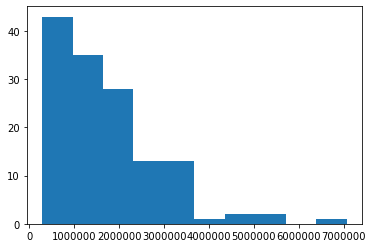

In [60]:
plt.hist(waterfront.price);

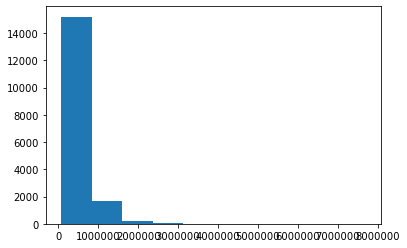

In [59]:
plt.hist(no_waterfront.price);

In [75]:
# perform welch's t-test (two-tailed by default)
welch = scipy.stats.ttest_ind(waterfront.price, no_waterfront.price, equal_var=False)
print('p-value:',welch[1]/2)

p-value: 3.470220628045268e-23


### P-value is 3.47e-23, which is lower than 0.05 alpha, indicating we can reject the null hypothesis in favor of the alternative, that houses on a waterfront sell for more on average than houses not on a waterfront.

## Stats Test 2: Zip Code vs. Price
### ANOVA Test
**Rationale:** Comparing means of several independent samples<br>
**Ho:** There is no difference in the average price of houses in different zip codes.<br>
**Ha:** Houses in different zip codes have different average house prices.

In [676]:
# Concatenate zipcode dummy variables with with main dataframe
X_dummies = pd.concat([df['price'], zip_dummies], axis=1)
formula = "price ~ "+ '+'.join(list(zip_dummies.columns))
model = ols(formula, X_dummies).fit()
table = sm.stats.anova_lm(model, typ=2)
table.sort_values('PR(>F)').head(10)

sum_sq   df            F         PR(>F)
zip98039  1.349927e+14  1.0  1611.813889   0.000000e+00
zip98004  1.605789e+14  1.0  1917.312755   0.000000e+00
zip98040  1.029211e+14  1.0  1228.878990  4.127097e-260
zip98112  8.604568e+13  1.0  1027.385948  5.199502e-219
zip98006  5.262880e+13  1.0   628.388162  3.075398e-136
zip98033  4.278113e+13  1.0   510.806899  1.763268e-111
zip98075  3.735075e+13  1.0   445.968136   9.416298e-98
zip98105  3.661641e+13  1.0   437.200116   6.829872e-96
zip98199  3.504893e+13  1.0   418.484416   6.444296e-92
zip98119  3.393523e+13  1.0   405.186836   4.325909e-89

# ?????? need to interpret this????

## Stats Test 3: ?????TBD????
### 2-Sample T-Test
**Rationale:** Comparing means of several independent samples<br>
**Ho:** Houses on a waterfront sell for the same amount on average as houses not on a waterfront.<br>
**Ha:** Houses on a waterfront sell for more on average than houses not on a waterfront.

# Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

## Look at Multicollinearity

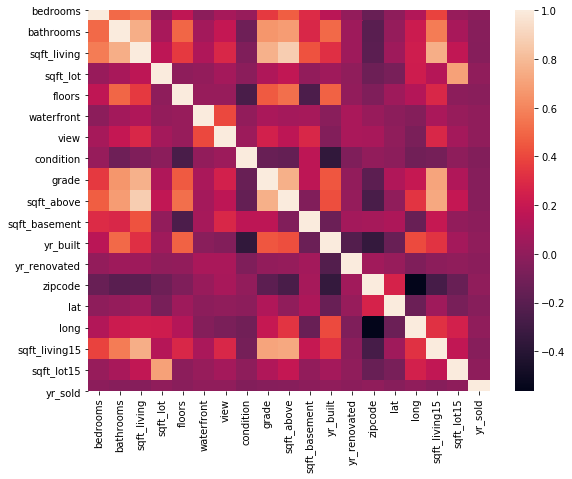

In [800]:
plt.figure(figsize=[9,7]);
sns.heatmap(df.iloc[:,3:].corr());

### Use stacking to look at feature pairs with highest correlations

In [801]:
corr=df.iloc[:,3:].corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.drop(columns=['level_1', 'level_0'], inplace = True)
corr.columns = ['correlation', 'pairs']
corr.drop_duplicates(inplace=True)
corr[(corr.correlation >0.75) & (corr.correlation <1.0)]

correlation                         pairs
47      0.876696     (sqft_living, sqft_above)
173     0.876696     (sqft_above, sqft_living)
46      0.762929          (sqft_living, grade)
154     0.762929          (grade, sqft_living)
161     0.758247           (grade, sqft_above)
179     0.758247           (sqft_above, grade)
21      0.755270      (bathrooms, sqft_living)
39      0.755270      (sqft_living, bathrooms)
54      0.755066  (sqft_living, sqft_living15)
306     0.755066  (sqft_living15, sqft_living)

### Check Variance Inflation Factor (VIF) Scores

In [802]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

predictors= df.iloc[:,3:]
predictors['Intercept']=1.0
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif.sort_values('VIF',ascending=False).head(10)

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF       features
10           inf  sqft_basement
9            inf     sqft_above
2            inf    sqft_living
19  2.322021e+07      Intercept
8   3.426364e+00          grade
1   3.338265e+00      bathrooms
16  2.972412e+00  sqft_living15
11  2.410312e+00       yr_built
17  2.041857e+00     sqft_lot15
3   2.005203e+00       sqft_lot

### Impact of removing multicollinear variables

In [805]:
y = df[['price']]
X = df.iloc[:,3:]
X.drop(columns=['sqft_living'], inplace=True) # barely impacts R-squared, so dropping it.
dropMultico = LinearRegression()
dropMultico.fit(X,y)
dropMultico.score(X,y)

0.6995126205083237

# Step 5: Train-Test Split 


### 5.1) Perform a train-test split of the data.

In [806]:
X = pd.concat([df.iloc[:,3:],new_features, zip_dummies], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5.2) Fit your scaler to training the data.

In [807]:
#your code here 

### 5.3) Transform the testing set with the scaler.

### 5.4) Fit the model to the training data.

In [808]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
model_1.score(X_train, y_train)

0.847532009129279

In [809]:
model_1.score(X_test, y_test)

0.8477683161350517

### 5.5) Use the model to predict on the training set and the test set.

In [810]:
y_train_pred = model_1.predict(X_train)
y_test_pred = model_1.predict(X_test)

### 5.6) Evaluate the training and test predictions using RMSE.

In [811]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_train, y_pred))

162853.80479094264

In [812]:
np.sqrt(mean_squared_error(y_test, y_test_pred))


142321.65155147493

### 5.7) Determine if your model is overfit.

In [ ]:
#your code here 

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.
- **Feature Selection** - There are many ways to do feature selection: filter methods, P-values, or recursive feature elimination (RFE). You should try multiple different techniques and combinations of them. For your final model, you will settle on a process of feature selection; this process should be clearly shown in your final notebook.


### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [7]:
# your code here

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [8]:
# your code here

## Step 7: Evaluate your different models in order to determine the best model overall.
- Model Interpretation: One of the benefits of a linear regression model is that you can interpret the coefficients of the model to derive insights. For example, which feature has the biggest impact on the price of the house? Was there a feature that you thought would be significant but was not? Think if you were a real estate agent helping clients price their house: what information would you find most helpful from this model?

## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/